In [4]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs



# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
               
import utils
# import signal_to_noise as sn
# import plotting_functions
# import xarray_extender as xe
import stats
import time_of_emrgence_calc as toe
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
# Scale the client to have n workers workers
client.cluster.scale(28)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:38869
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:45829'
 -         Start Nanny at: 'tcp://127.0.0.1:39503'
 -         Start Nanny at: 'tcp://127.0.0.1:38851'
 -         Start Nanny at: 'tcp://127.0.0.1:37297'
 -         Start Nanny at: 'tcp://127.0.0.1:34267'
 -         Start Nanny at: 'tcp://127.0.0.1:38543'
 -         Start Nanny at: 'tcp://127.0.0.1:39173'
 -         Start Nanny at: 'tcp://127.0.0.1:41791'
 -         Start Nanny at: 'tcp://127.0.0.1:43231'
 -         Start Nanny at: 'tcp://127.0.0.1:36735'
 -         Start Nanny at: 'tcp://127.0.0.1:33607'
 -         Start Nanny at: 'tcp://127.0.0.1:37265'
 -         Start Nanny at: 'tcp://127.0.0.1:37381'
 -         Start Nanny at: 'tcp://127.0.0.1:41343'
 -         Start Nanny at: 'tcp://127.0.0.1:37403'
 -         Start Nanny at: 'tcp://127.0.0.1:34891'
 -         Start Nanny at: 'tcp://127.0.0

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38869,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:40299,Total threads: 1
Dashboard: /proxy/41337/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:45829,


In [6]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [7]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [19]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'lat': 90, 'lon': 120},
                    use_cftime=True)['temperature']

# best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

In [20]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [21]:
base_period_ds_count = base_period_ds.count(dim='time')

In [22]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [23]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

# Testing Methods

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [31]:
best_ds = best_ds.sel(lat=slice(-45, -35), lon=slice(135, 160))

In [32]:
# Try with a belt latittude and longitude
base_period_ds = base_period_ds.sel(lat=slice(-45, -35), lon=slice(135, 160))

In [26]:
window=20

In [33]:
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':25, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS =   {'lat':5, 'lon':5, 'time':-1}

In [34]:
best_ds = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).persist()

In [35]:
best_ds

<xarray.DataArray 'temperature' (time: 175, lat: 10, lon: 25)>
dask.array<rechunk-merge, shape=(175, 10, 25), dtype=float32, chunksize=(175, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -43.5 -42.5 -41.5 ... -38.5 -37.5 -36.5 -35.5
  * lon      (lon) float32 135.5 136.5 137.5 138.5 ... 156.5 157.5 158.5 159.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [36]:
%%time
stats_test_1d_array_ttest = partial(toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

ufunc_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims=[['time']], 
    #exclude_dims={'time'},
    vectorize=True,
    output_dtypes=float, 
    dask='parallelized')

ttest_1d_ds_subset = xr.apply_ufunc(
    stats_test_1d_array_ttest,
    best_ds,
    **ufunc_kwargs).compute()

CPU times: user 2.63 s, sys: 423 ms, total: 3.05 s
Wall time: 9.58 s


In [37]:
# The time is at the start for this calc, whilst for the rolling window it is centered.
time_1d = ttest_1d_ds_subset.time.values
half_window = int(np.ceil(window/2))

In [38]:
ttest_1d_ds_subset = ttest_1d_ds_subset.dropna(dim='time')
ttest_1d_ds_subset['time'] = time_1d[half_window:-half_window]

In [39]:
best_ds_window = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rolling(time=window, center=True, min_periods=window).construct('window_dim').persist() 
base_period_window_ds = base_period_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rename({'time':'window_dim'}).persist()

In [40]:
best_ds.shape

(175, 10, 25)

In [41]:
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [42]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 2.49 s, sys: 240 ms, total: 2.73 s
Wall time: 7.07 s


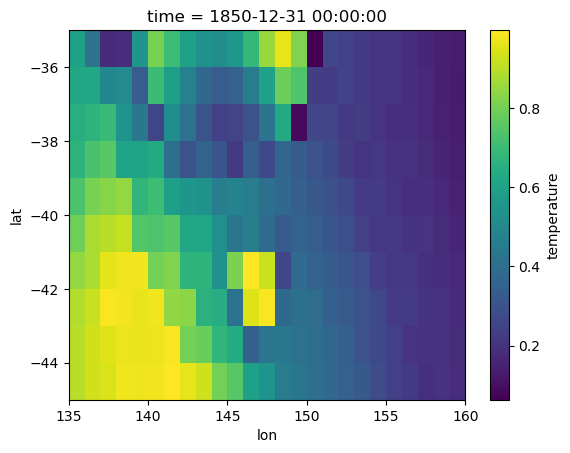

In [43]:
ttest_ds.isel(time=0).plot()

In [44]:
lat_lon_sp = dict(lat=-39, lon=145, method='nearest')

In [45]:
ttest_1d_1p = stats_test_1d_array_ttest(best_ds.sel(**lat_lon_sp))

In [60]:
# The xarray rolling seems to be ignoring the min periods areguement here. You can 
# see by remving the first and last 10, then it works
xr.testing.assert_allclose(ttest_ds.sel(**lat_lon_sp).isel(time=slice(10, -10)), ttest_1d_ds_subset.sel(**lat_lon_sp))

In [61]:
# This can also be seen here.
# The smallest it goes down to is 10 years.
# So slice(0, 10) will be equal to the 0th value, slice(0, 11) will be the first value etc.
# This is confirmed here.
toe.return_ttest_pvalue(
    best_ds.sel(**lat_lon_sp).isel(time=slice(0, 12)), # The first 12 year
    best_ds.sel(**lat_lon_sp).isel(time=slice(0, 50)) # The base period
)

0.3281165275628757

In [62]:
ttest_ds.sel(**lat_lon_sp).isel(time=slice(0, 5)).values

array([0.22, 0.29, 0.33, 0.68, 0.57])

In [63]:
ttest_ds.sel(**lat_lon_sp).isel(time=slice(10, -10))

<xarray.DataArray 'temperature' (time: 155)>
array([0.33, 0.39, 0.7 , 0.93, 0.56, 0.5 , 0.58, 0.56, 0.64, 0.81, 0.93,
       0.81, 0.9 , 0.81, 0.93, 0.99, 0.83, 0.96, 0.9 , 0.82, 0.88, 0.62,
       0.69, 0.76, 0.88, 0.65, 0.48, 0.58, 0.67, 0.57, 0.48, 0.74, 0.81,
       0.94, 0.75, 0.77, 0.53, 0.53, 0.32, 0.33, 0.08, 0.03, 0.01, 0.01,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.05, 0.09, 0.12,
       0.08, 0.11, 0.13, 0.17, 0.25, 0.27, 0.31, 0.22, 0.18, 0.17, 0.12,
       0.12, 0.14, 0.19, 0.21, 0.16, 0.14, 0.04, 0.05, 0.03, 0.04, 0.05,
       0.02, 0.04, 0.01, 0.01, 0.01, 0.04, 0.04, 0.07, 0.03, 0.05, 0.06,
       0.05, 0.02, 0.04, 0.05, 0.3 , 0.31, 0.58, 0.66, 0.78, 0.92, 0.76,
       0.4 , 0.09, 0.11, 0.09, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])
Coordinates:
    lat      float32 -38.5
    lon      float32 145.5
  * time     (time) object 1860-12-31 00:00:00 ... 2014-12-31 00:00:00

In [64]:
ttest_1d_ds_subset.sel(**lat_lon_sp)

<xarray.DataArray 'temperature' (time: 155)>
array([0.33, 0.39, 0.7 , 0.93, 0.56, 0.5 , 0.58, 0.56, 0.64, 0.81, 0.93,
       0.81, 0.9 , 0.81, 0.93, 0.99, 0.83, 0.96, 0.9 , 0.82, 0.88, 0.62,
       0.69, 0.76, 0.88, 0.65, 0.48, 0.58, 0.67, 0.57, 0.48, 0.74, 0.81,
       0.94, 0.75, 0.77, 0.53, 0.53, 0.32, 0.33, 0.08, 0.03, 0.01, 0.01,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.05, 0.09, 0.12,
       0.08, 0.11, 0.13, 0.17, 0.25, 0.27, 0.31, 0.22, 0.18, 0.17, 0.12,
       0.12, 0.14, 0.19, 0.21, 0.16, 0.14, 0.04, 0.05, 0.03, 0.04, 0.05,
       0.02, 0.04, 0.01, 0.01, 0.01, 0.04, 0.04, 0.07, 0.03, 0.05, 0.06,
       0.05, 0.02, 0.04, 0.05, 0.3 , 0.31, 0.58, 0.66, 0.78, 0.92, 0.76,
       0.4 , 0.09, 0.11, 0.09, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])
Coordinates:
    lat      float32 -38.5
    lon      float32 145.5
  * time     (time) object 1860-12-31 00:00:00 ... 2014-12-31 00:00:00

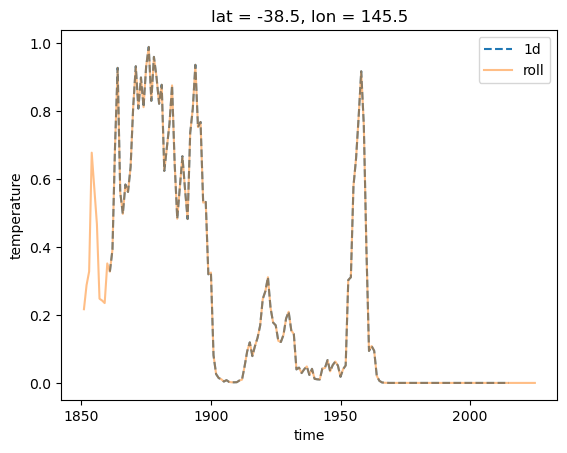

In [65]:
# Can see here, that there is more points at the end and start
ttest_1d_ds_subset.sel(**lat_lon_sp).plot(label='1d', linestyle='--')
ttest_ds.sel(**lat_lon_sp).plot(label='roll', alpha=0.5)
plt.legend()

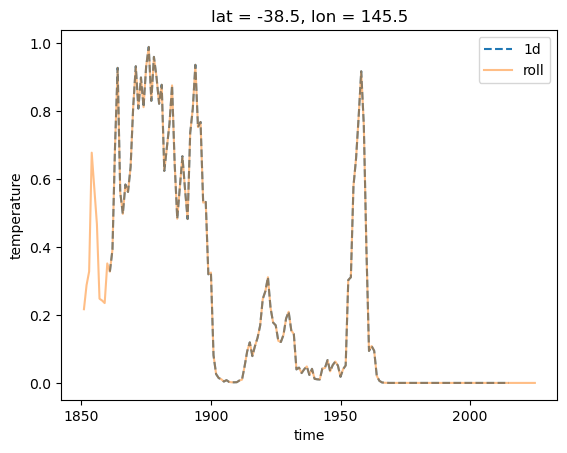

In [55]:
ttest_1d_ds_subset.sel(**lat_lon_sp).plot(label='1d', linestyle='--')
ttest_ds.sel(**lat_lon_sp).plot(label='roll', alpha=0.5)
plt.legend()

In [56]:
ttest_ds.sel(**lat_lon_sp).isel(time=slice(20,None))

<xarray.DataArray 'temperature' (time: 155)>
array([0.93, 0.81, 0.9 , 0.81, 0.93, 0.99, 0.83, 0.96, 0.9 , 0.82, 0.88,
       0.62, 0.69, 0.76, 0.88, 0.65, 0.48, 0.58, 0.67, 0.57, 0.48, 0.74,
       0.81, 0.94, 0.75, 0.77, 0.53, 0.53, 0.32, 0.33, 0.08, 0.03, 0.01,
       0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.05, 0.09,
       0.12, 0.08, 0.11, 0.13, 0.17, 0.25, 0.27, 0.31, 0.22, 0.18, 0.17,
       0.12, 0.12, 0.14, 0.19, 0.21, 0.16, 0.14, 0.04, 0.05, 0.03, 0.04,
       0.05, 0.02, 0.04, 0.01, 0.01, 0.01, 0.04, 0.04, 0.07, 0.03, 0.05,
       0.06, 0.05, 0.02, 0.04, 0.05, 0.3 , 0.31, 0.58, 0.66, 0.78, 0.92,
       0.76, 0.4 , 0.09, 0.11, 0.09, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])
Coordinates:
    lat      float32 -38.5
    lon      float32 145.5
  * time     (time) object 1870-12-31 00:00:00 ... 2024-12-31 00:00:00

In [ ]:
# When removing the start and the end they match perfectly now
ttest_1d_ds_subset.sel(**lat_lon_sp).plot(label='1d', linestyle='--')
ttest_ds.sel(**lat_lon_sp).isel(time=slice(10,-10)).plot(label='roll', alpha=0.5)
plt.legend()

Task was destroyed but it is pending!
task: <Task pending name='Task-20952' coro=<TCP.write() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py:260> cb=[IOLoop.add_future.<locals>.<lambda>() at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/ioloop.py:685]>
Task was destroyed but it is pending!
task: <Task pending name='Task-20755' coro=<TCP.write() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py:260> cb=[IOLoop.add_future.<locals>.<lambda>() at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/ioloop.py:685]>
Task exception was never retrieved
future: <Task finished name='Task-20954' coro=<TCP.write() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py:260> exception=CommClo

 - Batched Comm Closed <TCP (closed) Scheduler connection to worker local=tcp://127.0.0.1:38869 remote=tcp://127.0.0.1:45622>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/batched.py", line 115, in _background_send
    nbytes = yield coro
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/gen.py", line 767, in run
    value = future.result()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py", line 263, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError
 - Batched Comm Closed <TCP (closed) Scheduler connection to worker local=tcp://127.0.0.1:38869 remote=tcp://127.0.0.1:45530>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py", line 298, in write
    raise

Task was destroyed but it is pending!
task: <Task pending name='Task-20948' coro=<TCP.write() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py:260> cb=[IOLoop.add_future.<locals>.<lambda>() at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/ioloop.py:685]>
Task was destroyed but it is pending!
task: <Task pending name='Task-20899' coro=<TCP.write() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py:260> cb=[IOLoop.add_future.<locals>.<lambda>() at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/ioloop.py:685]>
Task was destroyed but it is pending!
task: <Task pending name='Task-20966' coro=<TCP.write() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py:260> cb=[IOLoop.add_fu

 - Connection to tcp://127.0.0.1:45482 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:32815', name: 12, status: running, memory: 2, processing: 2> (stimulus_id='handle-worker-cleanup-1712640483.2549248')
 - Worker process 2645373 was killed by signal 2
 - Worker process 2645396 exited with status 1
 - Worker process 2645402 exited with status 1
 - Worker process 2645371 exited with status 1
 - Worker process 2645397 exited with status 1
 - Worker process 2645334 exited with status 1
 - Connection to tcp://127.0.0.1:45640 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:38001', name: 19, status: running, memory: 2, processing: 2> (stimulus_id='handle-worker-cleanup-1712640483.267986')
 - Worker process 2645355 exited with status 1
 - Batched Comm Closed <TCP (closed) Scheduler connection to worker local=tcp://127.0.0.1:38869 remote=tcp://127.0.0.1:45640>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib

Process Dask Worker process (from Nanny):
2024-04-09 15:28:03,519 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-04-09 15:28:03,522 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-04-09 15:28:03,523 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/g/data/hh5/public/apps/minic

 - Restarting worker


te
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select(timeout)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(timeout, max_ev)
KeyboardInterrupt
Traceback (most recent call last):

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/nanny.py", line 976, in run
    await worker.finished()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/core.py", line 629, in finished
    await self._event

 - Restarting worker


lib/python3.10/asyncio/events.py", line 778, in set_event_loop
    get_event_loop_policy().set_event_loop(loop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/events.py", line 738, in get_event_loop_policy
    if _event_loop_policy is None:
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._targe

 - Restarting worker


tedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select(timeout)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(time

 - Restarting worker
 - Restarting worker
 - Restarting worker
 - Restarting worker
 - Restarting worker
 - Worker process 2645350 was killed by signal 2
 - Worker process 2645347 was killed by signal 2
 - Worker process 2645426 was killed by signal 2
 - Restarting worker
 - Connection to tcp://127.0.0.1:45554 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:42813', name: 25, status: running, memory: 1, processing: 2> (stimulus_id='handle-worker-cleanup-1712640483.8435435')
 - Connection to tcp://127.0.0.1:45584 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:40131', name: 5, status: running, memory: 1, processing: 2> (stimulus_id='handle-worker-cleanup-1712640483.8449528')
 - Connection to tcp://127.0.0.1:45480 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:36551', name: 6, status: running, memory: 2, processing: 2> (stimulus_id='handle-worker-cleanup-1712640483.8470535')
 - Lost all workers
 - Worker process 2645343 was killed by signal

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/multiprocessing/spawn.py", line 129, in _main
    return self._bootstrap(parent_sentinel)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/multiprocessing/process.py", line 332, in _bootstrap
    threading._shutdown()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/threading.py", line 1537, in _shutdown
    atexit_call()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/concurrent/futures/thread.py", line 31, in _python_exit
    t.join()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock

 - Worker process 2645391 was killed by signal 2
 - Worker process 2645386 was killed by signal 2
 - Worker process 2645338 was killed by signal 2
 - Closing Nanny at 'tcp://127.0.0.1:40919'. Reason: nanny-close-gracefully
 - Closing Nanny at 'tcp://127.0.0.1:34891'. Reason: nanny-close-gracefully
 - Closing Nanny at 'tcp://127.0.0.1:37297'. Reason: nanny-close-gracefully
 - Register worker <WorkerState 'tcp://127.0.0.1:40091', name: 25, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:40091
 - Starting established connection to tcp://127.0.0.1:60398
 - Register worker <WorkerState 'tcp://127.0.0.1:32837', name: 13, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:32837
 - Starting established connection to tcp://127.0.0.1:60266
 - Register worker <WorkerState 'tcp://127.0.0.1:35607', name: 12, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:35607
 - Starting e